# Domain transfer: toy example without importances

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [31]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(6, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 6)))
        out = self.fc2(h1)
        return out

In [32]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

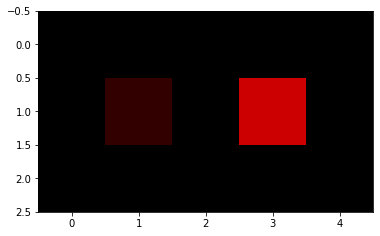

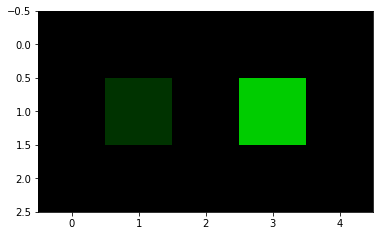

In [33]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

True ratio domain A: 0.5
Count: tensor([137, 119]) Ratio in this batch: tensor([0.5352, 0.4648])


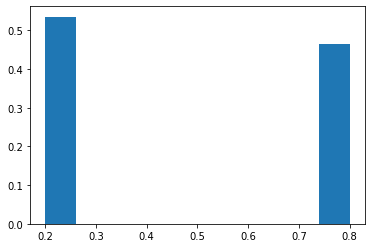

True ratio domain B: 0.5
Count: tensor([121, 135]) Ratio in this batch: tensor([0.4727, 0.5273])


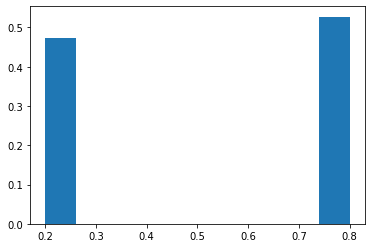

In [34]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [35]:
# Initialize the networks
generator_A = Generator()
generator_B = Generator()
discriminator = Discriminator()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []


sampled_batch_size = 64 # The amount of images sampled using importance sampling
for epoch in range(5):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Generated images
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)

        discriminated_A = discriminator(torch.cat((real_A, fake_B)))
        discriminated_B = discriminator(torch.cat((fake_A, real_B)))
        
        Lmin = (discriminated_A).sum()
        Lplus = (discriminated_B).sum()
        
        loss_d = - discriminator(
            torch.cat((real_A, fake_B.detach()))).sum() + discriminator(
            torch.cat((fake_A.detach(), real_B))).sum()
        loss_g = discriminator(
            torch.cat((real_A, fake_B))).sum() - discriminator(
            torch.cat((fake_A, real_B))).sum()

        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_d.backward()
        loss_g.backward()

        # Optimization step
        optimizer_d.step()
        optimizer_g.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item())

step 0 loss_g:  -17.720657348632812 loss_d:  17.720657348632812
step 500 loss_g:  -16.71826934814453 loss_d:  16.71826934814453
step 1000 loss_g:  -17.551490783691406 loss_d:  17.551490783691406
step 1500 loss_g:  -17.31229019165039 loss_d:  17.31229019165039
step 2000 loss_g:  -16.580284118652344 loss_d:  16.580284118652344
step 2500 loss_g:  -17.21977996826172 loss_d:  17.21977996826172
step 3000 loss_g:  -17.105079650878906 loss_d:  17.105079650878906
step 3500 loss_g:  -16.762393951416016 loss_d:  16.762393951416016
step 4000 loss_g:  -17.380859375 loss_d:  17.380859375
step 4500 loss_g:  -15.830535888671875 loss_d:  15.830535888671875
step 5000 loss_g:  -17.525436401367188 loss_d:  17.525436401367188
step 5500 loss_g:  -17.789012908935547 loss_d:  17.789012908935547
step 6000 loss_g:  -16.596378326416016 loss_d:  16.596378326416016
step 6500 loss_g:  -17.300209045410156 loss_d:  17.300209045410156
step 7000 loss_g:  -16.52654266357422 loss_d:  16.52654266357422
step 7500 loss_g:  

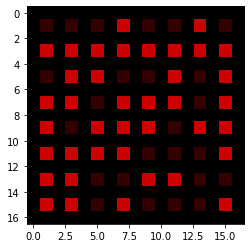

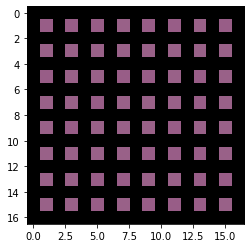

True ratio domain A 0.5
Count: tensor([122, 134]) Ratio in this batch: tensor([0.4766, 0.5234])


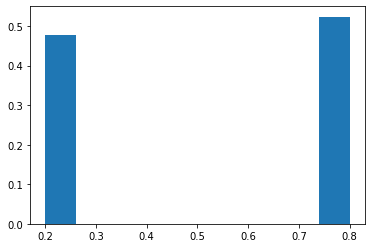

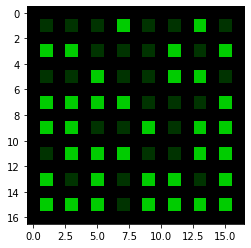

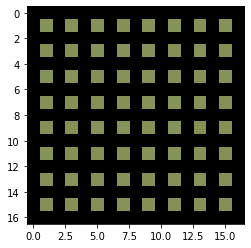

True ratio domain B 0.5
Count: tensor([124, 132]) Ratio in this batch: tensor([0.4844, 0.5156])


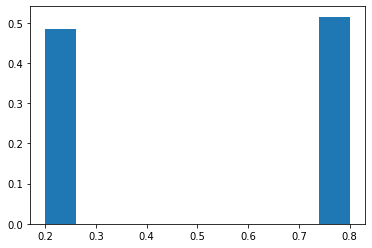

In [27]:
visualize_img_batch(real_A[:64])
visualize_img_batch(fake_B.detach()[:64])
print('True ratio domain A {}'.format(ratio_A))
plot_hist(real_A)

visualize_img_batch(real_B[:64])
visualize_img_batch(fake_A.detach()[:64])
print('True ratio domain B {}'.format(ratio_B))
plot_hist(real_B)

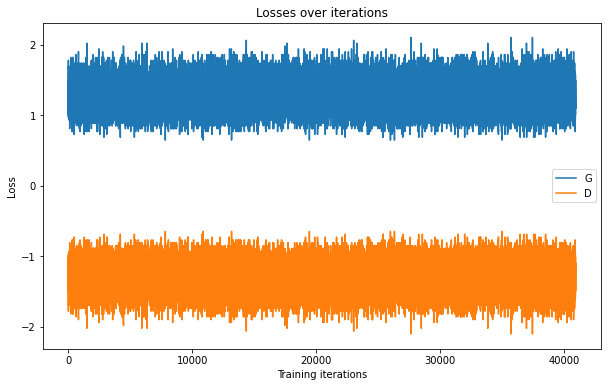

In [28]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

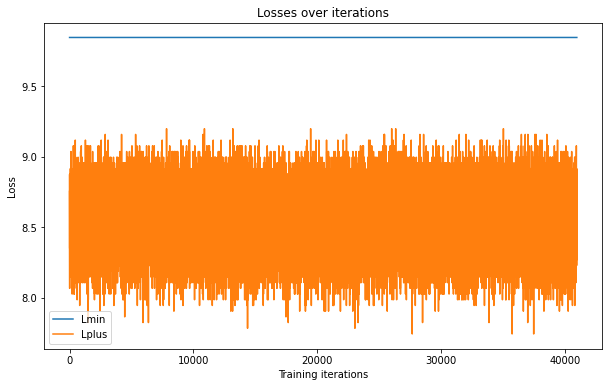

In [29]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

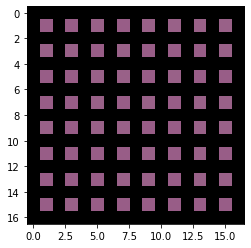

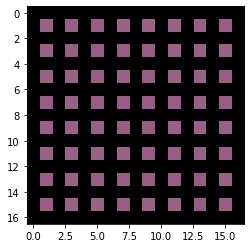

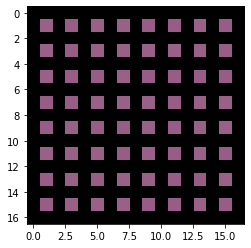

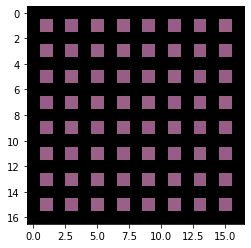

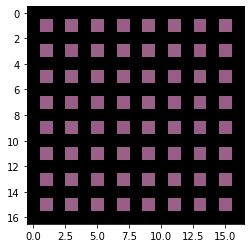

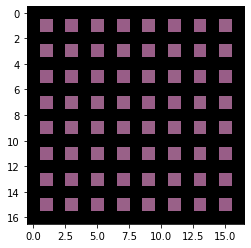

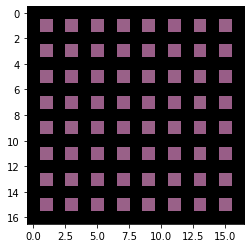

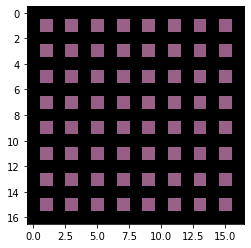

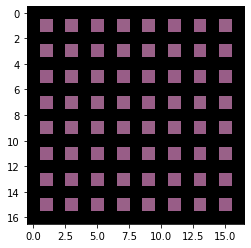

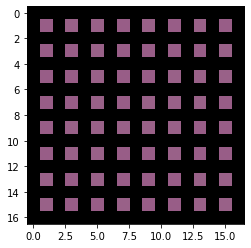

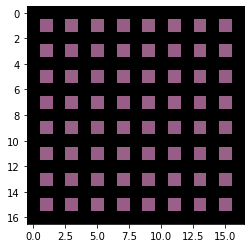

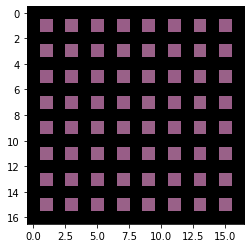

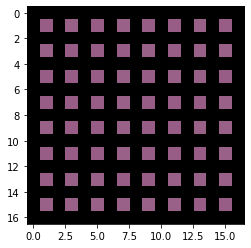

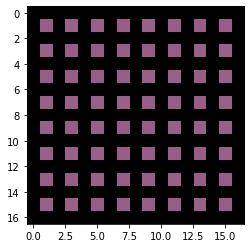

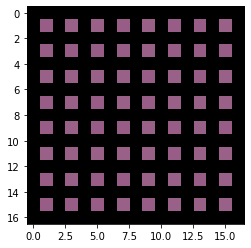

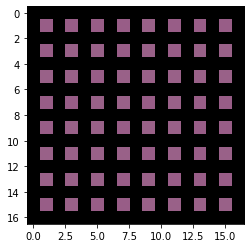

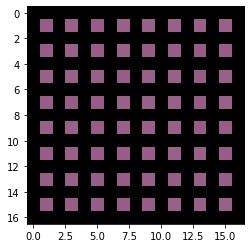

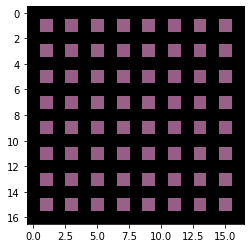

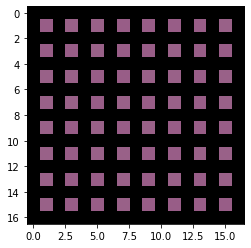

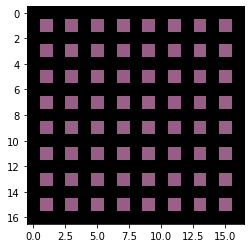

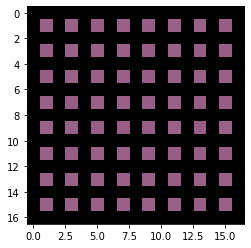

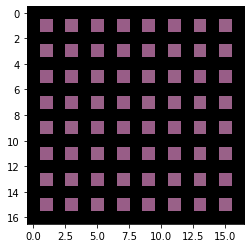

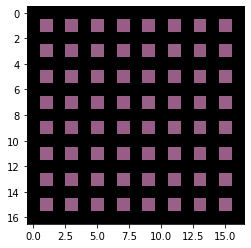

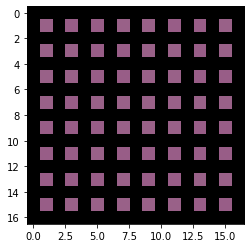

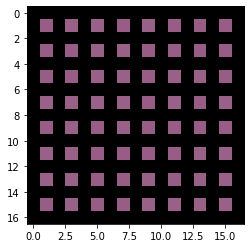

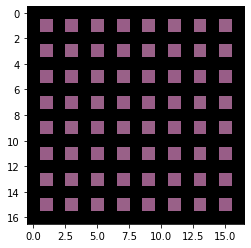

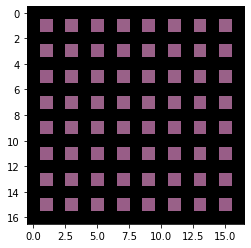

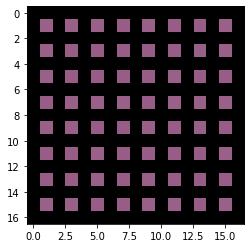

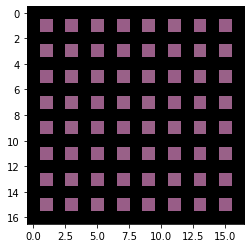

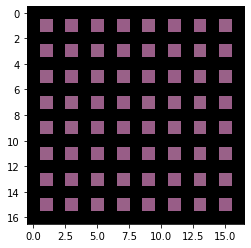

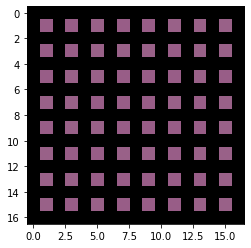

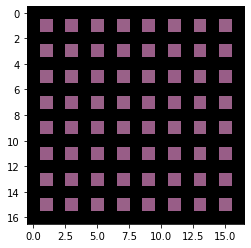

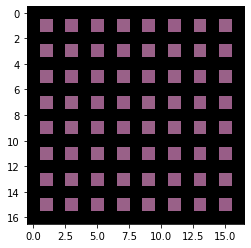

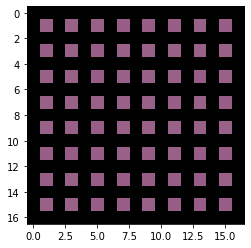

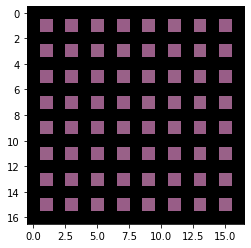

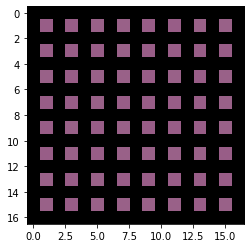

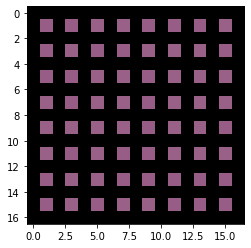

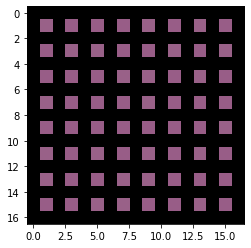

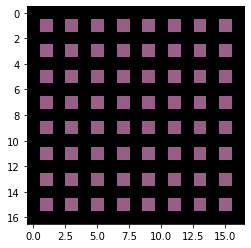

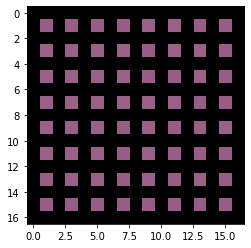

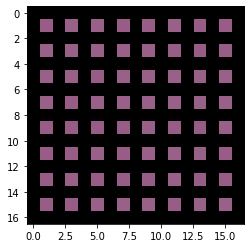

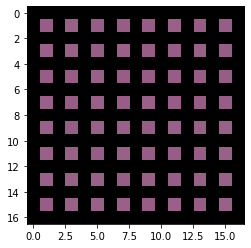

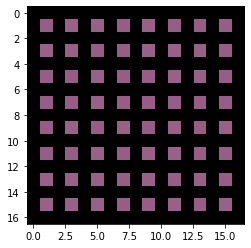

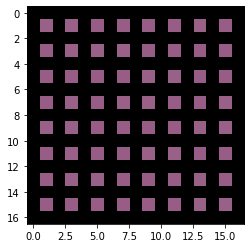

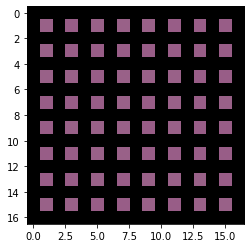

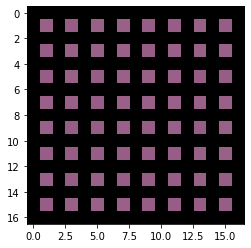

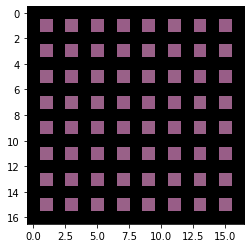

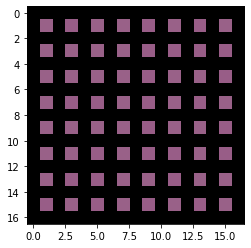

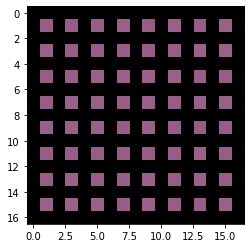

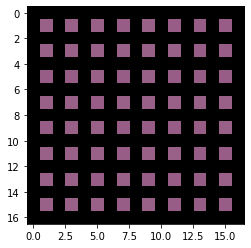

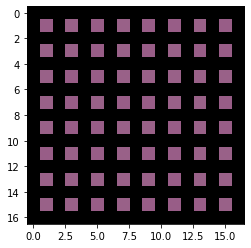

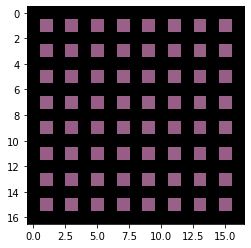

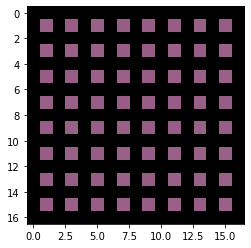

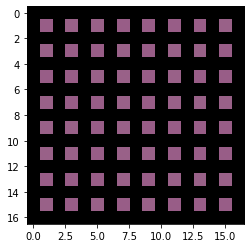

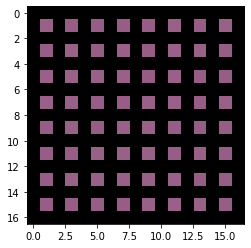

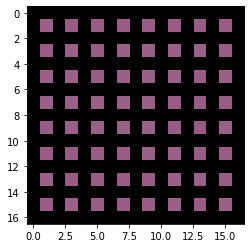

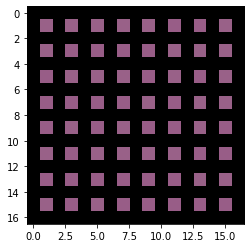

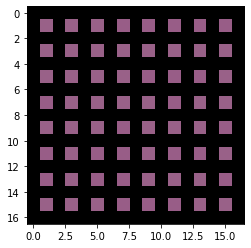

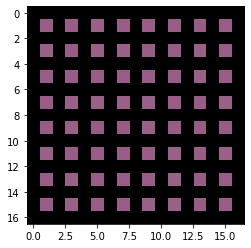

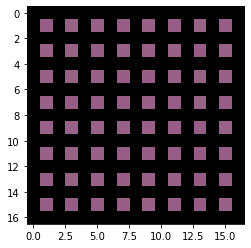

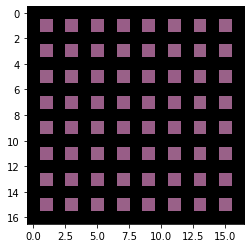

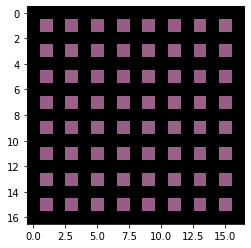

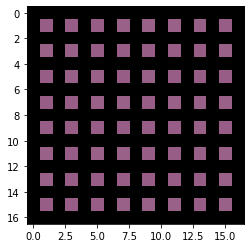

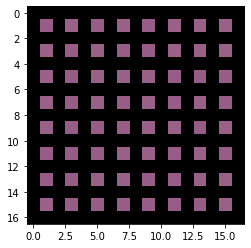

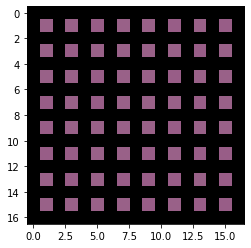

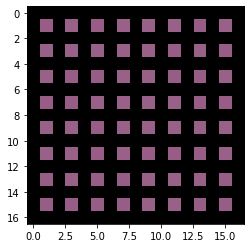

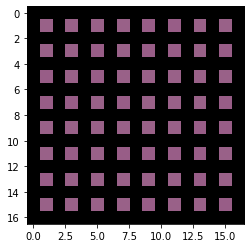

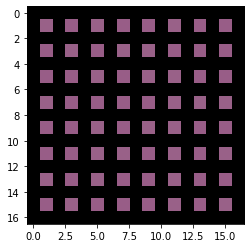

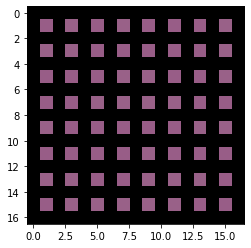

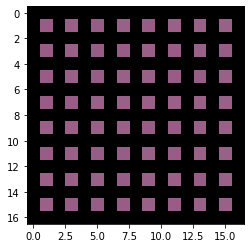

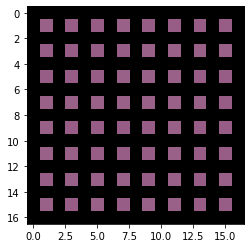

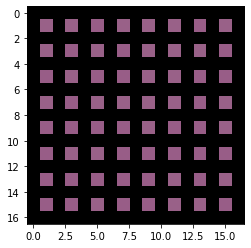

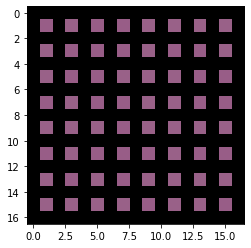

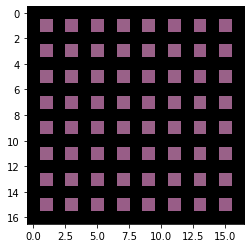

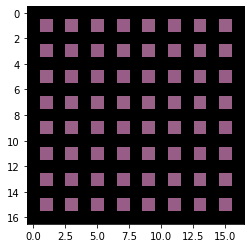

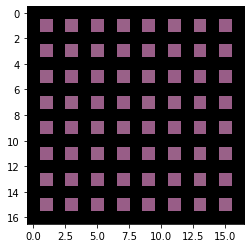

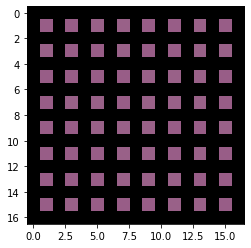

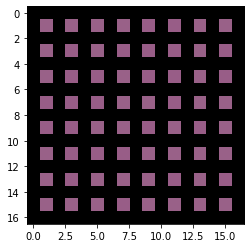

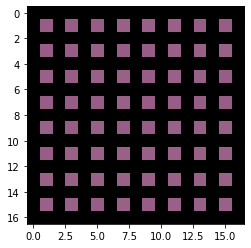

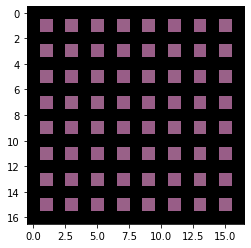

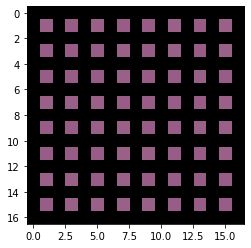

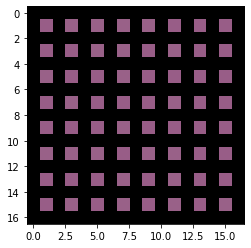

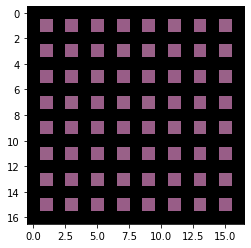

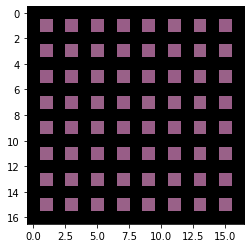

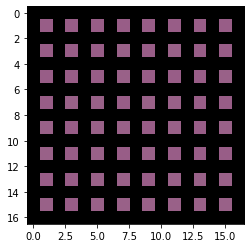

In [30]:
for img in samples_B:
    visualize_img_batch(img[:64])